## Application of deep learning approach to classify SARS-CoV-2 variants


### Coding Notebook
### Install and load the following libraries and packages

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import random
import tensorflow as tf
from keras import utils as np_utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier  
import keras
from keras import utils as np_utils
from numpy import array
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score,ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, GRU, LSTM
from keras.layers import Dense, Concatenate, Flatten
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
# Set seeds
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print(keras.__version__)

3.10.0


### Loading datasets and preprocessing

dataset_2 - sequence dataset with over 26000 used for training and validating the model <br>
dataset_3 - sequences to validate the model


In [4]:
dataset_2 = '../data/sequences.aln.fas' # huge dataset with 26k sequences
dataset_3 = '../data/validation.sequences.fas'

In [5]:
#Converting sequence data into data frame
#Ensure the fasta sequences are in one-liner and not blocks
#The sequence file had been pre-processed to include varinat names in the sequnce headers. Check file in fasta format.

#inputfile = [dataset_2,dataset_3]

def preprocess(inputfile):
    lines = []
    header = []
    with open (inputfile, 'r') as fasta_file:
    
        for line in fasta_file:
            if line.startswith(">"):
            #extract fasta headers
                lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))
            
            next
            #extract sequence lines
            if not line.startswith(">"):
                header.append(line.replace("\n",''))

            
    #Create dictionary of header and sequences and create a dataframe
    data = {lines[i]:header[i] for i in range(len(header))}
    data = pd.DataFrame(list(data.items()),columns = ['Seq_ID','sequence']) 

    data["sequence"] = data["sequence"].str.upper() #ensure the sequence is un uppercase. Important for encoding
    data["Variant_Id"] = data["Seq_ID"].apply(lambda i: i.split('/')[0]) #extracting variant names from sequnce file
    data = data.drop("Seq_ID", axis=1)
    
    return data



dataset_2 = preprocess(dataset_2)
dataset_3 = preprocess(dataset_3)


<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\w'
C:\Users\MHC V(D)J\AppData\Local\Temp\ipykernel_7364\2666058838.py:15: SyntaxWarning: invalid escape sequence '\w'
  lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))


Plot number of sequences for each variant

📊 Training dataset - sample count per class:
Variant_Id
Gamma      5597
Alpha      5511
Delta      5495
Omicron    5162
Beta       4271
Name: count, dtype: int64

🧮 Total sequences in training dataset: 26036

📊 Validation dataset - sample count per class:
Variant_Id
Beta       1403
Alpha       625
Delta       494
Gamma       437
Omicron     103
Name: count, dtype: int64

🧮 Total sequences in validation dataset: 3062

📝 Variant counts saved to: variant_distribution\variant_counts.txt


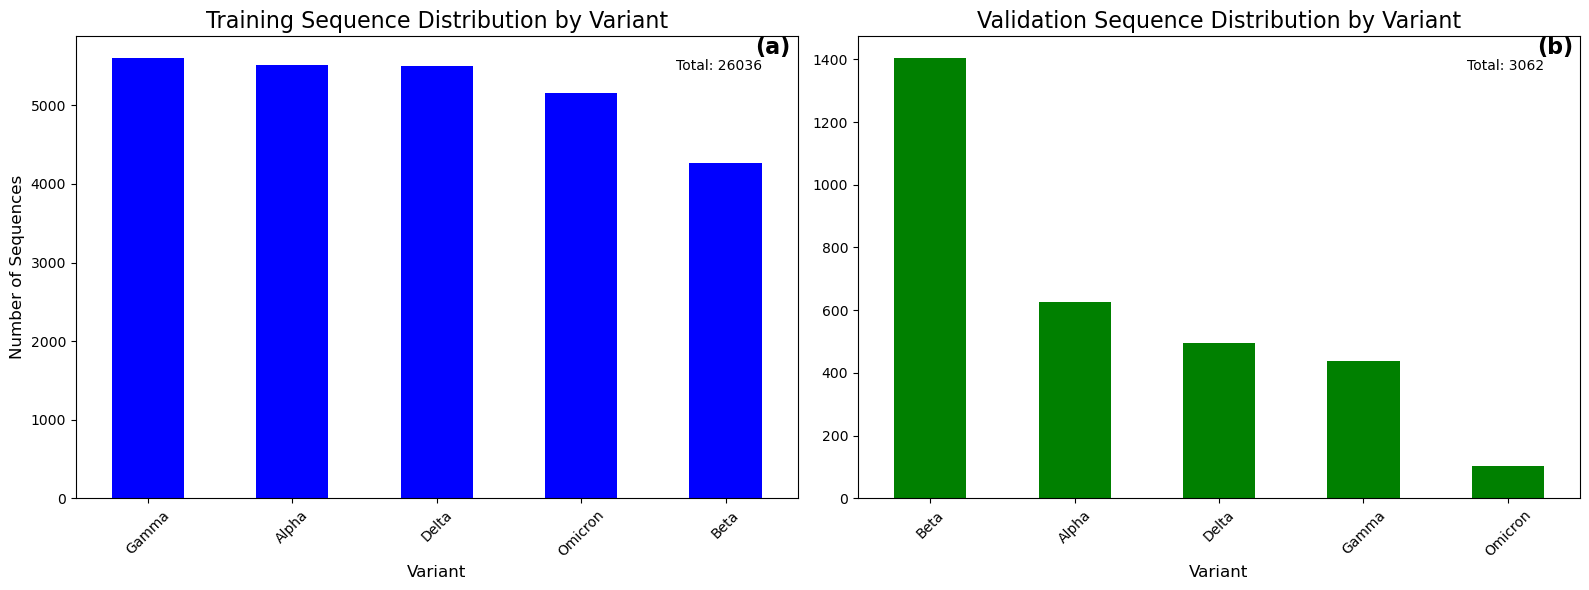

✅ Combined plot with independent y-axis saved to: variant_distribution\variant_distribution_combined_independent_y.png


In [6]:
# Create output directory
output_dir = "variant_distribution"
os.makedirs(output_dir, exist_ok=True)

# Capitalize variant names
dataset_2["Variant_Id"] = dataset_2["Variant_Id"].astype(str).str.capitalize()
dataset_3["Variant_Id"] = dataset_3["Variant_Id"].astype(str).str.capitalize()

# Count variant IDs
class_counts_2 = dataset_2["Variant_Id"].value_counts()
total_count_2 = class_counts_2.sum()

class_counts_3 = dataset_3["Variant_Id"].value_counts()
total_count_3 = class_counts_3.sum()

# Print counts
print("📊 Training dataset - sample count per class:")
print(class_counts_2)
print(f"\n🧮 Total sequences in training dataset: {total_count_2}\n")

print("📊 Validation dataset - sample count per class:")
print(class_counts_3)
print(f"\n🧮 Total sequences in validation dataset: {total_count_3}\n")

# Save counts to a text file
counts_path = os.path.join(output_dir, "variant_counts.txt")
with open(counts_path, 'w') as f:
    f.write("Training Dataset (dataset_2):\n")
    f.write(class_counts_2.to_string())
    f.write(f"\n\nTotal: {total_count_2}\n\n")
    
    f.write("Validation Dataset (dataset_3):\n")
    f.write(class_counts_3.to_string())
    f.write(f"\n\nTotal: {total_count_3}\n")

print(f"📝 Variant counts saved to: {counts_path}")

# Plot both in subplots with independent y-scales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Independent y-scale

# Training plot
class_counts_2.plot(kind="bar", color="blue", ax=axes[0])
axes[0].set_title("Training Sequence Distribution by Variant", fontsize=16)
axes[0].set_xlabel("Variant", fontsize=12)
axes[0].set_ylabel("Number of Sequences", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].text(0.95, 0.95, f"Total: {total_count_2}", transform=axes[0].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Validation plot
class_counts_3.plot(kind="bar", color="green", ax=axes[1])
axes[1].set_title("Validation Sequence Distribution by Variant", fontsize=16)
axes[1].set_xlabel("Variant", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].text(0.95, 0.95, f"Total: {total_count_3}", transform=axes[1].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
# Annotate 'a' and 'b'
axes[0].text(0.99, 1.0, "(a)", transform=axes[0].transAxes,
             fontsize=16, fontweight='bold', ha='right', va='top')
axes[1].text(0.99, 1.0, "(b)", transform=axes[1].transAxes,
             fontsize=16, fontweight='bold', ha='right', va='top')

plt.tight_layout()

# Save combined plot
plot_path = os.path.join(output_dir, "variant_distribution_combined_independent_y.png")
plt.savefig(plot_path, dpi=600, bbox_inches='tight', format='png')
plt.show()

print(f"✅ Combined plot with independent y-axis saved to: {plot_path}")


### Assign variant name to numerical form

gamma - 0 \
delta - 1 \
beta - 2 \
alpha - 3 \
omicron - 4

In [7]:
def variant_to_numerical(sequence_data):
    """
    Function to map convetional variant names to numeric
    pass a sequence data with column named "Variant_ID".
    
    """
    
    variant = {"Gamma" : 0, "Delta" : 1, "Beta" : 2, "Alpha" : 3, "Omicron":4}
    
    
    sequence_data["Variant_Id"] = sequence_data["Variant_Id"].map(variant)
    
    return sequence_data
    

In [8]:
variant_to_numerical(dataset_2)

dataset_2.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3


In [9]:
def encode_seq(seq_data):
    """
    Function to convert nucleotides to binary form and hot-encoded

    Arguments :
    seq_data = sequence dataframe with "sequence" and "Variant_ID" columns

    char : total number of unique characters in the whole dataset. This is used to 
    bin : array list of zeros corresponding to the number of characters

    """

    ntds = []
    for i in seq_data['sequence']:
        for seq in i:
            ntd = seq.strip()
            ntds.append(ntd.upper())
        
    char = list(set(ntds))
    
    bin = [0] * len(char)
    bin0  = [0] * len(char)
    bin1  = [0] * len(char)
    bin2  = [0] * len(char)
    bin3  = [0] * len(char)
    
    #Create a dictionary of arrays to the seqeunce characters
    Encode = {}

    for i in char:
        if i == 'A':
            bin0[0] = 1
            Encode[i] = bin0
        elif i == 'C':
            bin1[1] = 1
            Encode[i] = bin1
        elif i == 'G':
            bin2[2] = 1
            Encode[i] = bin2
        elif i == 'T':
            bin3[3] = 1
            Encode[i] = bin3
        else:
            Encode[i] = bin
    
      #convert the sequence characters to encoded form and append to the list

    encoded_list = []

    for seq in seq_data["sequence"]:
        encoded_list.append([Encode[x] for x in seq])

    return encoded_list

### Encoding sequences

In [10]:
#call function to encode the sequences and convert to array form
X_mine_data_kmer_2 = np.array(encode_seq(dataset_2))

#np.save("../../my_array", X_mine_data_kmer) #just setting DIR where to store this. Next time no need to run the process again

#X_mine_data_kmer_2 = np.load("../../my_array.npy")


In [11]:
#set variable for 
y_mine_kmer_2 = dataset_2['Variant_Id']

#y_mine_kmer_2.shape

In [12]:
dataset_2.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3


### **Model Fitting**
Split the dataset into training and validation (80:20) ration.

In [13]:
#Split dataset into training and validation
X_train, X_test, y_train, y_test = train_test_split(X_mine_data_kmer_2, y_mine_kmer_2, random_state = 42, stratify = y_mine_kmer_2)

#have the data in tensor-readable form. I also don't know what that means.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
X_train.shape

(19527, 3854, 13)

In [15]:
X_test.shape

(6509, 3854, 13)

Set the model 

In [16]:
# Define input shape
input_layer = Input(shape=X_mine_data_kmer_2.shape[1:])

# Shared CNN layers
x = Conv1D(filters=54, kernel_size=6, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=5)(x)
x = Dropout(0.5)(x)

x = Conv1D(filters=27, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.2)(x)

x = Conv1D(filters=14, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.1)(x)

x = Conv1D(filters=7, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3)(x)

# BiLSTM branch only
x = Bidirectional(LSTM(512))(x)
x = Dropout(0.01)(x)

# Dense layers (unchanged)
x = Dense(256, activation='relu')(x)
x = Dense(128)(x)
x = Dense(64)(x)
x = Dense(32)(x)
x = Dense(16)(x)

# Output layer
output = Dense(5, activation='softmax')(x)

# Define the model
cnn_bilstm_model = Model(inputs=input_layer, outputs=output)

# Compile the model
cnn_bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
cnn_bilstm_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3854, 13)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3849, 54)            │           4,266 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 769, 54)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 769, 54)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 769, 27)             │           4,401 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 256, 27)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256, 27)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 256, 14)             │             770 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 85, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 85, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 85, 7)               │             203 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 28, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1024)                │       2,129,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,445,805 (9.33 MB)

 Trainable params: 2,445,805 (9.33 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Fit the model on the dataset
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=8,
    restore_best_weights=True
)

history = cnn_bilstm_model.fit(
    X_train, y_train,
    batch_size=1000,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.2073 - loss: 1.6373 - val_accuracy: 0.2149 - val_loss: 1.6063
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.2123 - loss: 1.6053 - val_accuracy: 0.2126 - val_loss: 1.6059
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.2116 - loss: 1.6052 - val_accuracy: 0.2149 - val_loss: 1.6057
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.2139 - loss: 1.6048 - val_accuracy: 0.1982 - val_loss: 1.6068
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.2182 - loss: 1.6044 - val_accuracy: 0.1982 - val_loss: 1.6054
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.2230 - loss: 1.6016 - val_accuracy: 0.4426 - val_loss: 1.5414
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.2934 - loss: 1.5525 - val_accuracy: 0.4316 - val_loss: 1.2805
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.4497 - loss: 1.2196 - val_accuracy: 0.4764 - val_loss:

In [21]:
# save the model to disk
#filename = 'cnn_model.sav'
#joblib.dump(cnn_model, 'cnn_model.sav')
 
# load the model from disk
#cnn_model_c = joblib.load(filename)


## Explore Results 

### a. Visualizing Model Accuracy and Loss for Training and Validation Sets


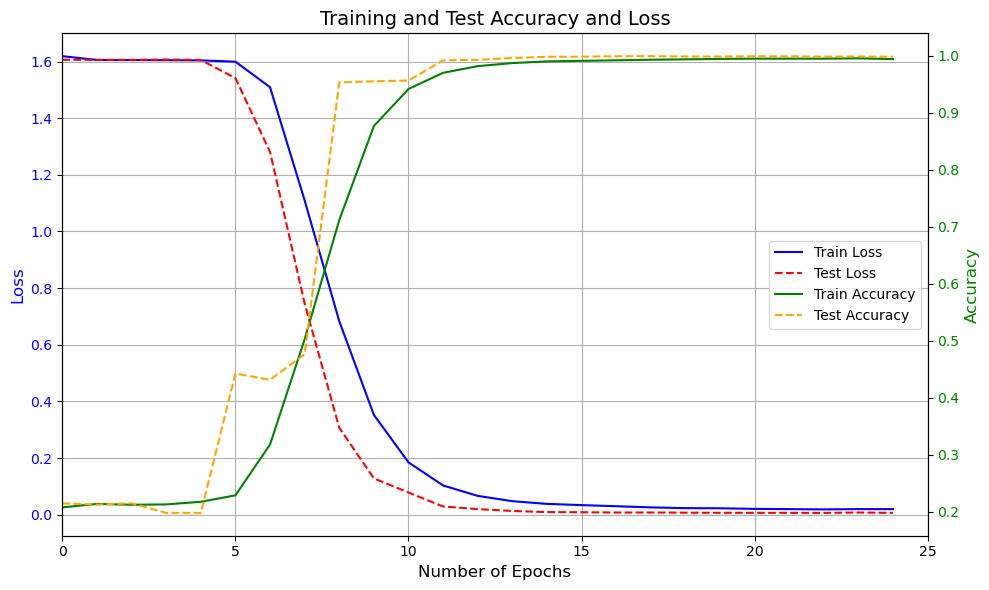

✅ Dual y-axis combined plot saved to: Test_Loss_Accuracy_curves\loss_accuracy_combined_dual_yaxes.png


In [22]:
import os
import matplotlib.pyplot as plt

# === Create output directory ===
output_dir = "Test_Loss_Accuracy_curves"
os.makedirs(output_dir, exist_ok=True)

# === Combined Plot with Dual Y-Axes ===
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot loss curves on left y-axis
ax1.set_xlabel("Number of Epochs", fontsize=12)
ax1.set_ylabel("Loss", color='blue', fontsize=12)
l1 = ax1.plot(history.history['loss'], color='blue', linestyle='-', label='Train Loss')
l2 = ax1.plot(history.history['val_loss'], color='red', linestyle='--', label='Test Loss')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlim(0, len(history.history['loss']))
ax1.grid(True)

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color='green', fontsize=12)
l3 = ax2.plot(history.history['accuracy'], color='green', linestyle='-', label='Train Accuracy')
l4 = ax2.plot(history.history['val_accuracy'], color='orange', linestyle='--', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor='green')

# Combine all legends
lines = l1 + l2 + l3 + l4
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right', fontsize=10, frameon=True)

# Title and layout
plt.title("Training and Test Accuracy and Loss", fontsize=14)
fig.tight_layout()

# Save figure
dual_plot_path = os.path.join(output_dir, "loss_accuracy_combined_dual_yaxes.png")
plt.savefig(dual_plot_path, dpi=600, bbox_inches='tight')
plt.show()

print(f"✅ Dual y-axis combined plot saved to: {dual_plot_path}")


### b. Visualization of Feature Importance Using Saliency Maps

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 3854, 13))']
  warnings.warn(msg)


✅ Saved saliency map to: saliency_maps/saliency_class_Gamma.png


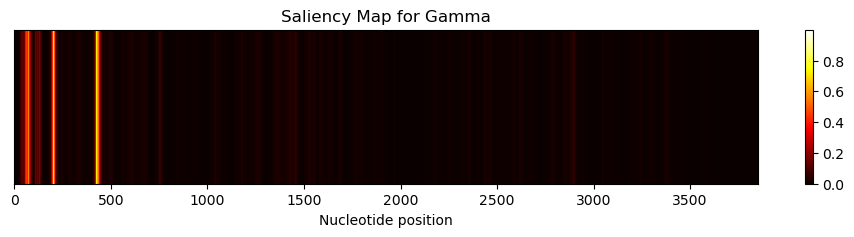

✅ Saved saliency map to: saliency_maps/saliency_class_Delta.png


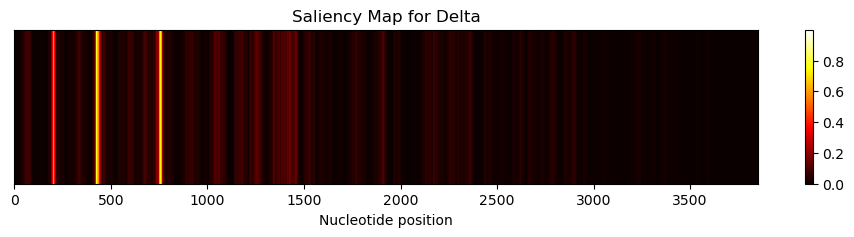

✅ Saved saliency map to: saliency_maps/saliency_class_Beta.png


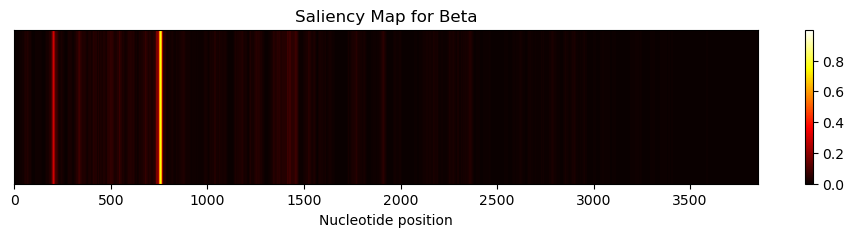

✅ Saved saliency map to: saliency_maps/saliency_class_Alpha.png


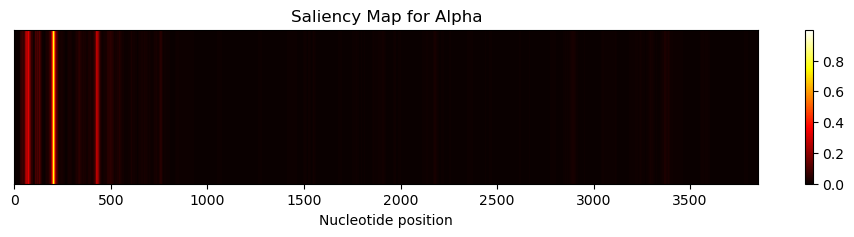

✅ Saved saliency map to: saliency_maps/saliency_class_Omicron.png


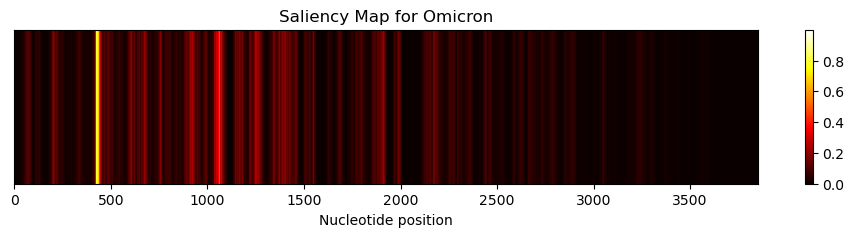

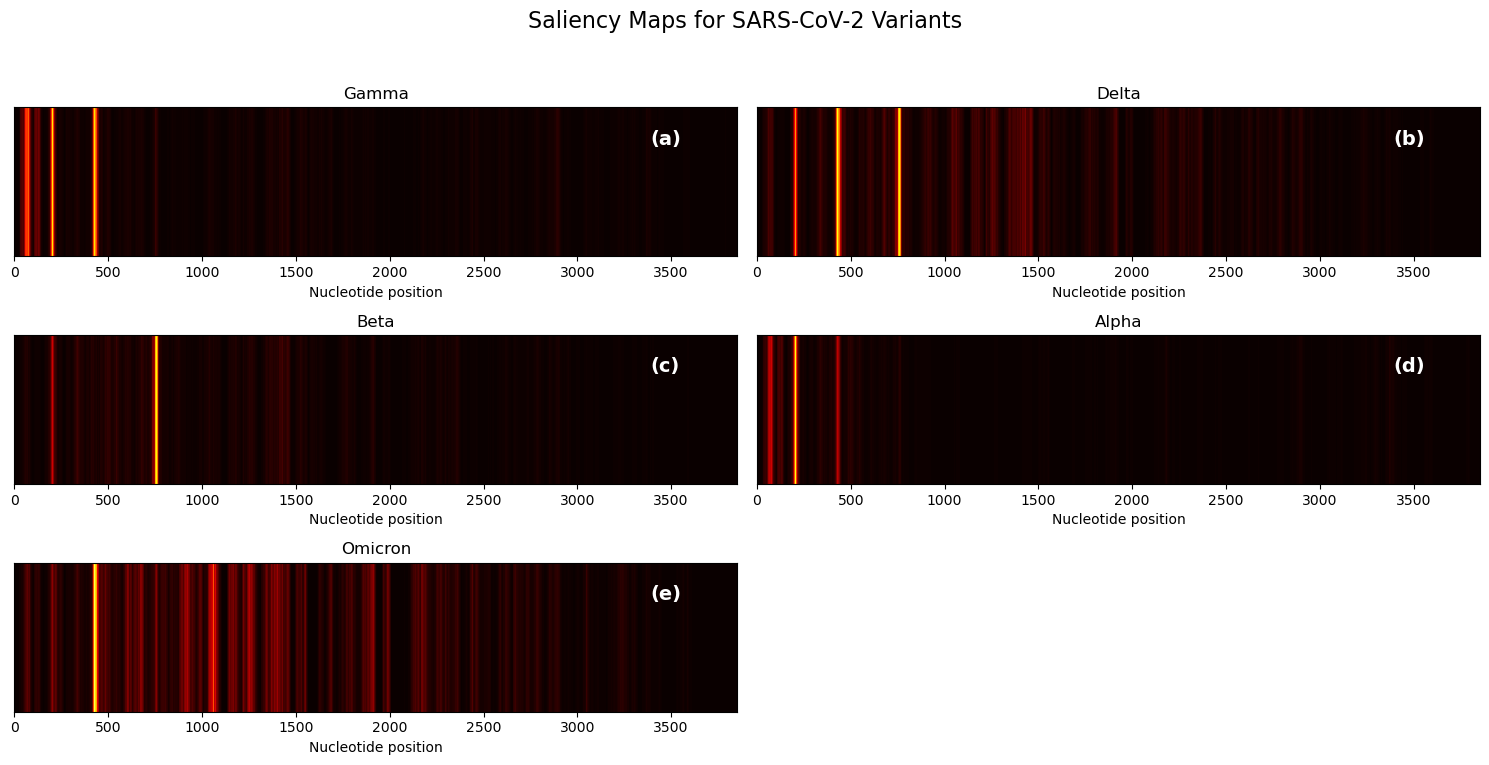


✅ Grid saliency plot saved to: saliency_maps/saliency_grid.png


In [23]:
# Create directory to save saliency maps
os.makedirs("saliency_maps", exist_ok=True)

# Define class name mapping
class_names = {
    0: "Gamma",
    1: "Delta",
    2: "Beta",
    3: "Alpha",
    4: "Omicron"
}

# Choose one input sample to explain
sample_index = 0
X_sample = X_test[sample_index:sample_index+1].astype(np.float32)

# Modify model's final activation (softmax → linear)
model_modifier = ReplaceToLinear()

# Create saliency object
saliency = Saliency(model=cnn_bilstm_model,
                    model_modifier=model_modifier,
                    clone=True)

# Prepare storage for grid plot
saliency_maps = []

# Loop over all output classes
num_classes = 5
for class_index in range(num_classes):
    score = CategoricalScore([class_index])
    saliency_map = saliency(score, X_sample)

    # Save individual saliency map
    plt.figure(figsize=(12, 2))
    plt.title(f'Saliency Map for {class_names[class_index]}')
    plt.imshow(saliency_map[0][np.newaxis, :], cmap='hot', aspect='auto')
    plt.colorbar()
    plt.xlabel('Nucleotide position')
    plt.yticks([])

    save_path = f"saliency_maps/saliency_class_{class_names[class_index]}.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight', transparent=False)
    print(f"✅ Saved saliency map to: {save_path}")
    plt.show()

    # Store for grid
    saliency_maps.append((saliency_map[0], class_names[class_index]))

# ---- GRID PLOT FOR ALL SALIENCY MAPS ----
fig, axes = plt.subplots(3, 2, figsize=(15, 8))  # 3 rows × 2 cols for 5 classes + 1 empty
axes = axes.flatten()

for i, (map_data, name) in enumerate(saliency_maps):
    axes[i].imshow(map_data[np.newaxis, :], cmap='hot', aspect='auto')
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Nucleotide position')
    axes[i].set_yticks([])

# Remove unused subplot (last one)
for j in range(len(saliency_maps), len(axes)):
    fig.delaxes(axes[j])
# Annotate saliency subplots (a) to (e) with white text
annotation_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
for i in range(len(saliency_maps)):
    axes[i].text(0.88, 0.85, annotation_labels[i],
                 transform=axes[i].transAxes,
                 fontsize=14, fontweight='bold',
                 color='white', ha='left', va='top')
fig.suptitle('Saliency Maps for SARS-CoV-2 Variants', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

grid_path = "saliency_maps/saliency_grid.png"
plt.savefig(grid_path, dpi=600, bbox_inches='tight', transparent=False)
plt.show()

print(f"\n✅ Grid saliency plot saved to: {grid_path}")


Processing Gamma...


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 3854, 13))']
  warnings.warn(msg)


✅ Saved: average_saliency_maps\Gamma_saliency.png
📄 CSV saved: average_saliency_maps\csv_top_salient_positions\Gamma_top_salient_positions.csv
Processing Delta...
✅ Saved: average_saliency_maps\Delta_saliency.png
📄 CSV saved: average_saliency_maps\csv_top_salient_positions\Delta_top_salient_positions.csv
Processing Beta...
✅ Saved: average_saliency_maps\Beta_saliency.png
📄 CSV saved: average_saliency_maps\csv_top_salient_positions\Beta_top_salient_positions.csv
Processing Alpha...
✅ Saved: average_saliency_maps\Alpha_saliency.png
📄 CSV saved: average_saliency_maps\csv_top_salient_positions\Alpha_top_salient_positions.csv
Processing Omicron...
✅ Saved: average_saliency_maps\Omicron_saliency.png
📄 CSV saved: average_saliency_maps\csv_top_salient_positions\Omicron_top_salient_positions.csv


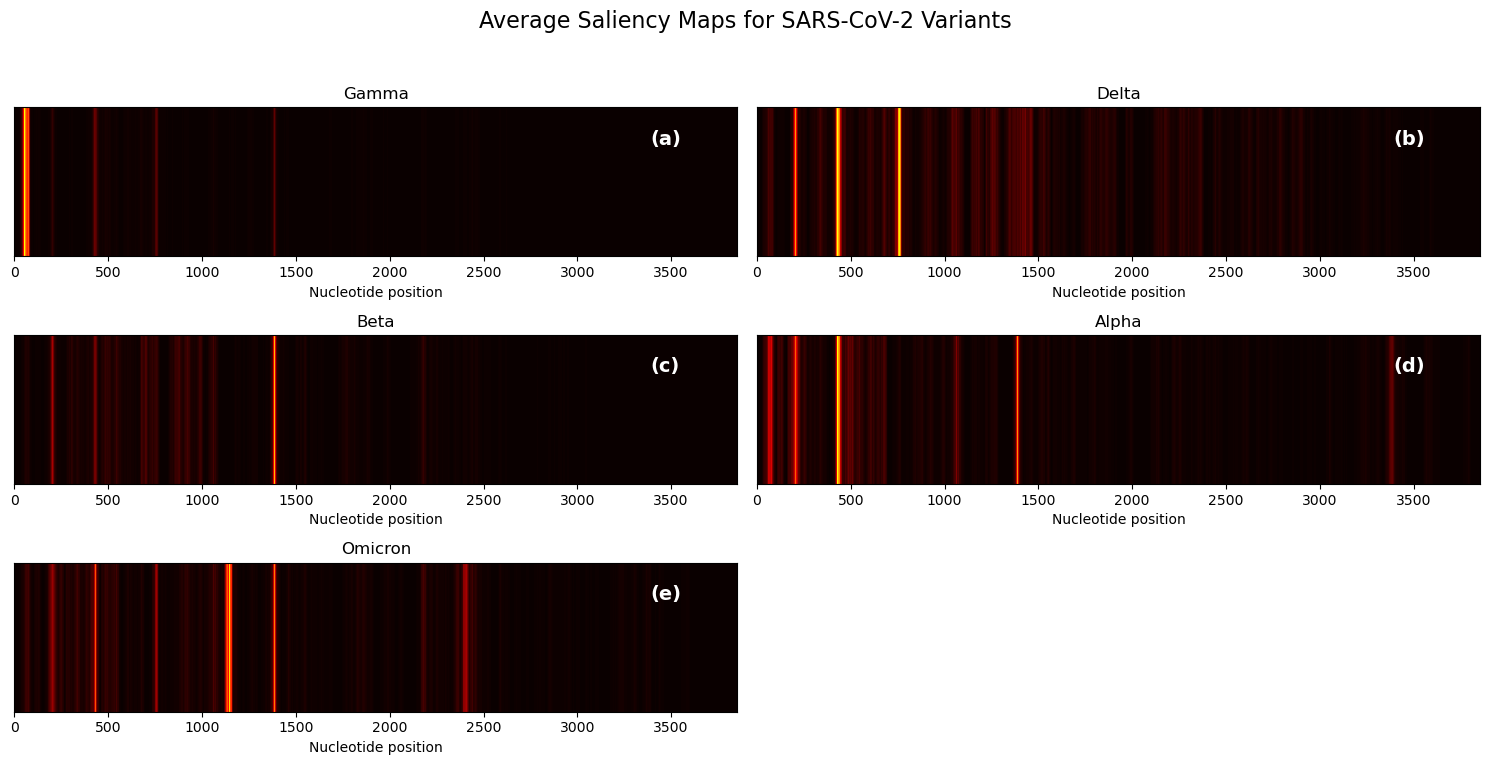


✅ Grid saliency plot saved to: average_saliency_maps\average_saliency_grid.png


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# === Output directory setup ===
output_dir = "average_saliency_maps"
csv_dir = os.path.join(output_dir, "csv_top_salient_positions")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

# Class names
class_names = ['Gamma', 'Delta', 'Beta', 'Alpha', 'Omicron']

def compute_and_save_avg_saliency(model, X_test, y_test, num_classes=5, top_k=10):
    model_modifier = ReplaceToLinear()
    saliency = Saliency(model=model, model_modifier=model_modifier, clone=True)

    # For grid plot storage
    avg_saliency_data = []

    for class_idx in range(num_classes):
        print(f"Processing {class_names[class_idx]}...")
        class_indices = np.where(np.argmax(y_test, axis=1) == class_idx)[0]
        if len(class_indices) == 0:
            print(f"⚠️ No samples found for class {class_names[class_idx]}")
            continue

        saliency_maps = []
        for idx in class_indices:
            X_sample = X_test[idx:idx+1].astype(np.float32)
            score = CategoricalScore([class_idx])
            sal_map = saliency(score, X_sample)
            saliency_maps.append(sal_map[0])  # shape: (sequence_length,)

        avg_saliency = np.mean(saliency_maps, axis=0)

        # === Save PNG plot ===
        plt.figure(figsize=(12, 2))
        plt.title(f'Average Saliency Map for {class_names[class_idx]}')
        plt.imshow(avg_saliency[np.newaxis, :], cmap='hot', aspect='auto')
        plt.colorbar()
        plt.xlabel('Nucleotide position')
        plt.yticks([])

        image_path = os.path.join(output_dir, f"{class_names[class_idx]}_saliency.png")
        plt.savefig(image_path, dpi=600, bbox_inches='tight', transparent=False)
        plt.close()
        print(f"✅ Saved: {image_path}")

        # === Extract and save top-k salient positions to CSV ===
        top_indices = np.argsort(avg_saliency)[-top_k:][::-1]  # highest to lowest
        top_values = avg_saliency[top_indices]
        df_top_salient = pd.DataFrame({
            'Nucleotide_Position': top_indices,
            'Saliency_Value': top_values
        })
        csv_path = os.path.join(csv_dir, f"{class_names[class_idx]}_top_salient_positions.csv")
        df_top_salient.to_csv(csv_path, index=False)
        print(f"📄 CSV saved: {csv_path}")

        # Store for grid plot
        avg_saliency_data.append((avg_saliency, class_names[class_idx]))

    # === GRID PLOT ===
    if avg_saliency_data:
        fig, axes = plt.subplots(3, 2, figsize=(15, 8))
        axes = axes.flatten()

        for i, (avg_map, name) in enumerate(avg_saliency_data):
            axes[i].imshow(avg_map[np.newaxis, :], cmap='hot', aspect='auto')
            axes[i].set_title(name)
            axes[i].set_xlabel('Nucleotide position')
            axes[i].set_yticks([])

        # Turn off any unused axes
        for j in range(len(avg_saliency_data), len(axes)):
            fig.delaxes(axes[j])

        annotation_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
        for i in range(len(avg_saliency_data)):
            axes[i].text(0.88, 0.85, annotation_labels[i],
                         transform=axes[i].transAxes,
                         fontsize=14, fontweight='bold',
                         color='white', ha='left', va='top')

        fig.suptitle('Average Saliency Maps for SARS-CoV-2 Variants', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        grid_path = os.path.join(output_dir, "average_saliency_grid.png")
        plt.savefig(grid_path, dpi=600, bbox_inches='tight', transparent=False)
        plt.show()
        print(f"\n✅ Grid saliency plot saved to: {grid_path}")

# === Run Function ===
compute_and_save_avg_saliency(cnn_bilstm_model, X_test, y_test, num_classes=5)


Processing Gamma...


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 3854, 13))']
  warnings.warn(msg)


✅ Saved: average_saliency_maps\Gamma_saliency.png
📄 CSV saved: average_saliency_maps\csv_salient_positions_above_0.2\Gamma_salient_positions_thresh_0.2.csv
Processing Delta...
✅ Saved: average_saliency_maps\Delta_saliency.png
📄 CSV saved: average_saliency_maps\csv_salient_positions_above_0.2\Delta_salient_positions_thresh_0.2.csv
Processing Beta...
✅ Saved: average_saliency_maps\Beta_saliency.png
📄 CSV saved: average_saliency_maps\csv_salient_positions_above_0.2\Beta_salient_positions_thresh_0.2.csv
Processing Alpha...
✅ Saved: average_saliency_maps\Alpha_saliency.png
📄 CSV saved: average_saliency_maps\csv_salient_positions_above_0.2\Alpha_salient_positions_thresh_0.2.csv
Processing Omicron...
✅ Saved: average_saliency_maps\Omicron_saliency.png
📄 CSV saved: average_saliency_maps\csv_salient_positions_above_0.2\Omicron_salient_positions_thresh_0.2.csv


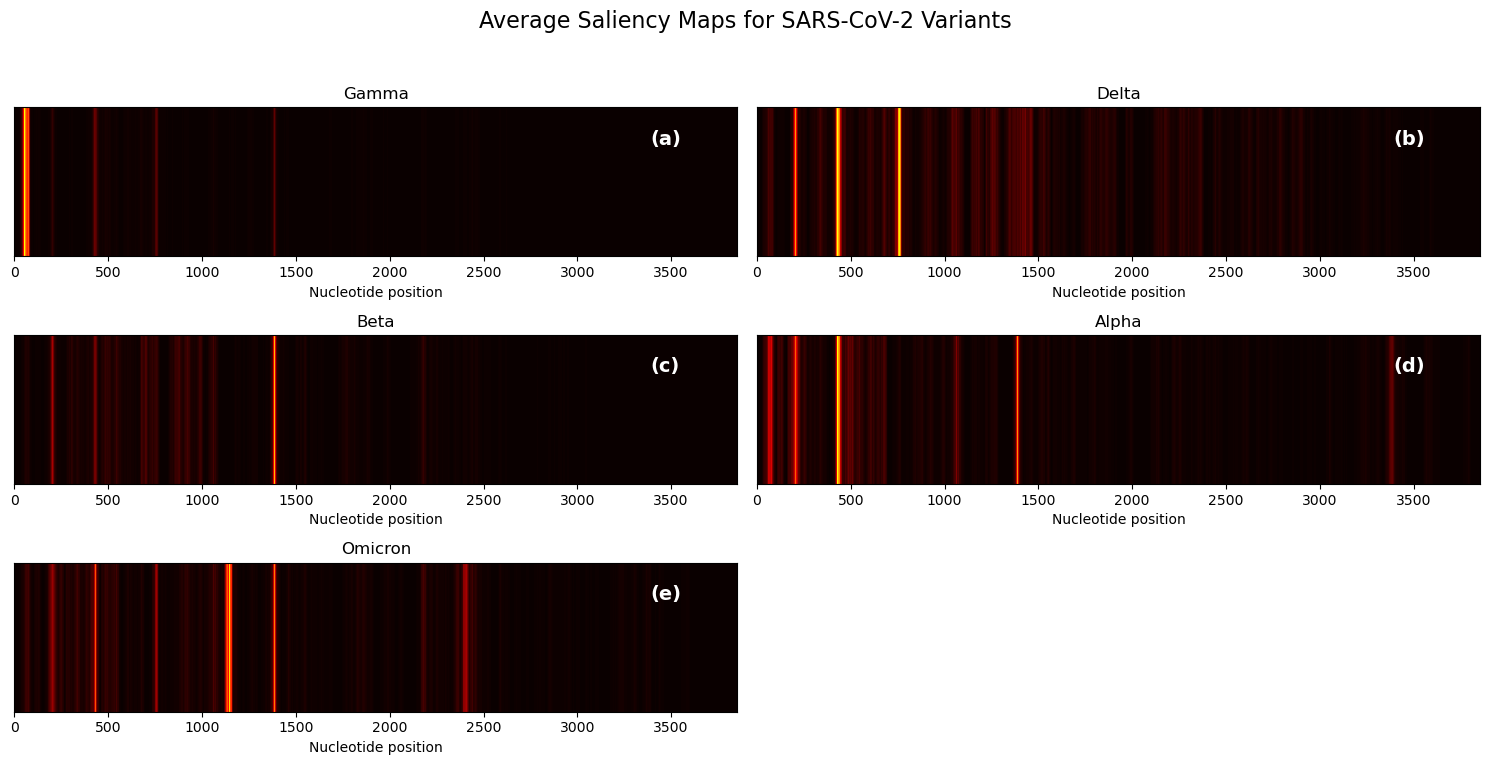


✅ Grid saliency plot saved to: average_saliency_maps\average_saliency_grid.png


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# === Output directory setup ===
output_dir = "average_saliency_maps"
csv_dir = os.path.join(output_dir, "csv_salient_positions_above_0.2")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

# Class names
class_names = ['Gamma', 'Delta', 'Beta', 'Alpha', 'Omicron']

def compute_and_save_avg_saliency(model, X_test, y_test, num_classes=5, saliency_threshold=0.2):
    model_modifier = ReplaceToLinear()
    saliency = Saliency(model=model, model_modifier=model_modifier, clone=True)

    avg_saliency_data = []

    for class_idx in range(num_classes):
        print(f"Processing {class_names[class_idx]}...")
        class_indices = np.where(np.argmax(y_test, axis=1) == class_idx)[0]
        if len(class_indices) == 0:
            print(f"⚠️ No samples found for class {class_names[class_idx]}")
            continue

        saliency_maps = []
        for idx in class_indices:
            X_sample = X_test[idx:idx+1].astype(np.float32)
            score = CategoricalScore([class_idx])
            sal_map = saliency(score, X_sample)
            saliency_maps.append(sal_map[0])  # shape: (sequence_length,)

        avg_saliency = np.mean(saliency_maps, axis=0)

        # === Save PNG plot ===
        plt.figure(figsize=(12, 2))
        plt.title(f'Average Saliency Map for {class_names[class_idx]}')
        plt.imshow(avg_saliency[np.newaxis, :], cmap='hot', aspect='auto')
        plt.colorbar()
        plt.xlabel('Nucleotide position')
        plt.yticks([])
        image_path = os.path.join(output_dir, f"{class_names[class_idx]}_saliency.png")
        plt.savefig(image_path, dpi=600, bbox_inches='tight', transparent=False)
        plt.close()
        print(f"✅ Saved: {image_path}")

        # === Extract positions above threshold and get bases ===
        salient_positions = np.where(avg_saliency >= saliency_threshold)[0]
        salient_values = avg_saliency[salient_positions]
        first_sample = X_test[class_indices[0]]

        # Decode one-hot to base
        base_dict = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
        base_list = []
        for pos in salient_positions:
            base_vector = first_sample[pos]
            if np.sum(base_vector) == 0:
                base_list.append('N')  # ambiguous base
            else:
                base_index = np.argmax(base_vector)
                base_list.append(base_dict.get(base_index, 'N'))

        df_salient = pd.DataFrame({
            'Nucleotide_Position': salient_positions,
            'Saliency_Value': salient_values,
            'Base': base_list
        })

        csv_path = os.path.join(csv_dir, f"{class_names[class_idx]}_salient_positions_thresh_{saliency_threshold}.csv")
        df_salient.to_csv(csv_path, index=False)
        print(f"📄 CSV saved: {csv_path}")

        avg_saliency_data.append((avg_saliency, class_names[class_idx]))

    # === GRID PLOT ===
    if avg_saliency_data:
        fig, axes = plt.subplots(3, 2, figsize=(15, 8))
        axes = axes.flatten()

        for i, (avg_map, name) in enumerate(avg_saliency_data):
            axes[i].imshow(avg_map[np.newaxis, :], cmap='hot', aspect='auto')
            axes[i].set_title(name)
            axes[i].set_xlabel('Nucleotide position')
            axes[i].set_yticks([])

        for j in range(len(avg_saliency_data), len(axes)):
            fig.delaxes(axes[j])

        annotation_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
        for i in range(len(avg_saliency_data)):
            axes[i].text(0.88, 0.85, annotation_labels[i],
                         transform=axes[i].transAxes,
                         fontsize=14, fontweight='bold',
                         color='white', ha='left', va='top')

        fig.suptitle('Average Saliency Maps for SARS-CoV-2 Variants', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        grid_path = os.path.join(output_dir, "average_saliency_grid.png")
        plt.savefig(grid_path, dpi=600, bbox_inches='tight', transparent=False)
        plt.show()
        print(f"\n✅ Grid saliency plot saved to: {grid_path}")

# === Run the function ===
compute_and_save_avg_saliency(cnn_bilstm_model, X_test, y_test, num_classes=5)


### c. Evaluation of Model Discrimination Using ROC Curves and AUC Metrics

In [ ]:
# Predict probabilities
y_pred_probs = cnn_bilstm_model.predict(X_test)

# Ensure output directory exists
os.makedirs('test_roc_auc_plots', exist_ok=True)

# Class name mapping
class_names = ['Gamma', 'Delta', 'Beta', 'Alpha', 'Omicron']

# Store ROC data for grid plotting
roc_data = []

# Plot and save individual ROC curves
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    auc_score = roc_auc_score(y_test[:, i], y_pred_probs[:, i])
    roc_data.append((fpr, tpr, auc_score, class_names[i]))

    # Individual plot
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {class_names[i]}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

    filename = f'roc_auc_plots/roc_curve_{class_names[i]}.png'
    plt.savefig(filename, dpi=600, bbox_inches='tight', transparent=False)
    plt.show()

    print(f'{class_names[i]} ROC AUC: {auc_score:.4f} (saved to {filename})')

# Create subplot grid (2x3) for all variants and one explanation panel
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i, (fpr, tpr, auc_score, name) in enumerate(roc_data):
    axes[i].plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('FPR')
    axes[i].set_ylabel('TPR')
    axes[i].legend(loc='lower right')
    axes[i].grid(True)

# Use last subplot for explanation text if unused
if len(roc_data) < rows * cols:
    explanation_ax = axes[len(roc_data)]
    explanation_ax.axis('off')  # Hide axes
    explanation_ax.text(
        0.05, 0.9,
        'TPR = True Positive Rate\nFPR = False Positive Rate',
        fontsize=12, verticalalignment='top'
    )
    explanation_ax.text(
        0.05, 0.5,
        'The ROC curve illustrates the\ntrade-off between sensitivity (TPR)\nand 1-specificity (FPR).\nAUC summarizes classification performance.',
        fontsize=11, verticalalignment='top'
    )

fig.suptitle('ROC Curves for SARS-CoV-2 Variants', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
annotation_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i in range(len(roc_data)):
    axes[i].text(0.06, 0.92, annotation_labels[i],
                 transform=axes[i].transAxes,
                 fontsize=13, fontweight='bold',
                 va='top', ha='left')
grid_filename = 'roc_auc_plots/roc_curve_grid.png'
plt.savefig(grid_filename, dpi=600, bbox_inches='tight', transparent=False)
plt.show()

print(f'\n✅ ROC curve grid saved to: {grid_filename}')

# Macro-average ROC AUC
macro_auc = roc_auc_score(y_test, y_pred_probs, average='macro')
print(f'\nMacro-average ROC AUC: {macro_auc:.4f}')


# Add annotation letters to ROC plots



### d. Model Calibration: Reliability Curve with Expected and Maximum Calibration Error (ECE & MCE)

In [ ]:
# Confidence Calibration

# === Setup ===
calibration_dir = "calibration_results"
os.makedirs(calibration_dir, exist_ok=True)
NUM_BINS = 10
MCE_BIN_THRESHOLD = 3  # Minimum samples required per bin to count toward MCE

# === Class names ===
class_names = ['Gamma', 'Delta', 'Beta', 'Alpha', 'Omicron']

# === Predictions ===
y_prob = cnn_bilstm_model.predict(X_test)  # Shape: (n_samples, n_classes)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)
confidences = np.max(y_prob, axis=1)
correctness = (y_pred == y_true)

# === Overall ECE and MCE ===
bins = np.linspace(0.0, 1.0, NUM_BINS + 1)
bin_indices = np.digitize(confidences, bins) - 1

bin_acc, bin_conf, bin_counts = [], [], []
ece, mce = 0.0, 0.0

print("\n📊 ECE Breakdown Per Bin:")
for i in range(NUM_BINS):
    bin_mask = bin_indices == i
    bin_size = np.sum(bin_mask)

    if bin_size > 0:
        bin_accuracy = np.mean(correctness[bin_mask])
        bin_confidence = np.mean(confidences[bin_mask])
        bin_ece = np.abs(bin_accuracy - bin_confidence) * (bin_size / len(y_true))

        bin_acc.append(bin_accuracy)
        bin_conf.append(bin_confidence)
        bin_counts.append(bin_size)

        ece += bin_ece

        if bin_size >= MCE_BIN_THRESHOLD:
            mce = max(mce, np.abs(bin_accuracy - bin_confidence))

        print(f"Bin {i+1}: Count={bin_size}, Confidence={bin_confidence:.3f}, "
              f"Accuracy={bin_accuracy:.3f}, ECE Contribution={bin_ece:.4f}")
    else:
        bin_acc.append(0.0)
        bin_conf.append(0.0)
        bin_counts.append(0)
        print(f"Bin {i+1}: Count=0, Confidence=0.000, Accuracy=0.000, ECE Contribution=0.0000")

# === Reliability Plot ===
filtered_bin_acc = []
filtered_bin_conf = []

for acc, conf, count in zip(bin_acc, bin_conf, bin_counts):
    if count > 0:
        filtered_bin_acc.append(acc)
        filtered_bin_conf.append(conf)

plt.figure(figsize=(6, 6))
plt.scatter(filtered_bin_conf, filtered_bin_acc, color='blue', label='Model', zorder=3)
plt.plot(filtered_bin_conf, filtered_bin_acc, linestyle='-', color='blue', alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration', zorder=1)
plt.title('Reliability Diagram (Confidence Calibration)')
plt.xlabel('Predicted Confidence')
plt.ylabel('True Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and show
plot_path = os.path.join(calibration_dir, 'reliability_diagram_corrected.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight', transparent=False)
plt.show()

print(f"\n📈 Final Expected Calibration Error (ECE): {ece:.4f}")
print(f"📉 Maximum Calibration Error (MCE): {mce:.4f}")
print(f"✅ Calibration plot saved to: {plot_path}")

# Save ECE metrics
results_text = f"""Corrected Confidence Calibration Results
=================================================
Expected Calibration Error (ECE): {ece:.4f}
Maximum Calibration Error (MCE):  {mce:.4f}
Saved plot: {plot_path}
"""
with open(os.path.join(calibration_dir, 'corrected_calibration_metrics.txt'), 'w') as f:
    f.write(results_text)
print("📝 Calibration metrics saved to: corrected_calibration_metrics.txt")

# === Per-Class ECE ===
def compute_per_class_ece(y_true, probs, n_bins=10):
    num_classes = probs.shape[1]
    per_class_ece = {}

    for class_idx in range(num_classes):
        class_confidences = probs[:, class_idx]
        class_true = (y_true == class_idx).astype(int)

        bins = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(class_confidences, bins) - 1
        ece = 0.0

        for i in range(n_bins):
            bin_mask = bin_indices == i
            if np.any(bin_mask):
                bin_acc = np.mean(class_true[bin_mask])
                bin_conf = np.mean(class_confidences[bin_mask])
                bin_prop = np.sum(bin_mask) / len(y_true)
                ece += np.abs(bin_acc - bin_conf) * bin_prop

        per_class_ece[class_idx] = ece

    return per_class_ece

# Compute and print per-class
per_class_ece = compute_per_class_ece(y_true, y_prob, n_bins=NUM_BINS)
print("\n📊 Per-Class Expected Calibration Error (ECE):")
for class_idx, ece_val in per_class_ece.items():
    print(f"{class_names[class_idx]}: {ece_val:.4f}")  # ✅ use real class name

# Save to file
per_class_path = os.path.join(calibration_dir, 'per_class_ece.txt')
with open(per_class_path, "w", encoding="utf-8") as f:
    f.write("Per-Class Expected Calibration Error (ECE):\n")
    for class_idx, ece_val in per_class_ece.items():
        f.write(f"{class_names[class_idx]}: {ece_val:.4f}\n")  # ✅ use real class name

print(f"\n✅ Per-class ECE saved to: {per_class_path}")

### e. Test Classification Report and F1 Score

In [ ]:
# Make predictions on test set
Y_pred_test_classes = np.argmax(cnn_bilstm_model.predict(X_test), axis=1)
Y_true_test = np.argmax(y_test, axis=1)

# Create output directory
output_dir = "test_evaluation_output"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "classification_f1_test_output.txt")

# Generate metrics
report_test = classification_report(
    Y_true_test, Y_pred_test_classes,
    target_names=["Gamma", "Delta", "Beta", "Alpha", "Omicron"]
)
f1_test = f1_score(Y_true_test, Y_pred_test_classes, average='macro')

# Print to console
print("\n📊 Classification Report (Test Set):")
print(report_test)
print(f"\n🎯 Macro F1 Score (Test Set): {f1_test:.4f}")

# Save to text file with UTF-8 encoding
with open(output_file, "w", encoding="utf-8") as f:
    f.write("📊 Classification Report (Test Set):\n")
    f.write(report_test)
    f.write(f"\n\n🎯 Macro F1 Score (Test Set): {f1_test:.4f}\n")

print(f"\n✅ Metrics saved to: {output_file}")


## Section 2: Model Evaluation on Independent Validation Dataset

A summary of the dataset

In [ ]:
variant_to_numerical(dataset_3)

dataset_3.head()

### Perform Hot-encoding on the dataset

In [ ]:
#call function to encode the sequences and convert to array form
X_mine_data_kmer_3 = np.array(encode_seq(dataset_3))

#np.save("../../my_array_3", X_mine_data_kmer) #just setting DIR where to store this. Next time no need to run the process again

#X_mine_data_kmer_3 = np.load("../../my_array_3.npy")

### Load saved model and test on the new dataset

In [ ]:
# load the model from disk
#cnn_model_loaded = joblib.load('cnn_model.sav')

#X_mine_data_kmer_3 = np.load("../../my_array_3.npy")

#X_mine_data_kmer_3.shape



In [ ]:
Y_pred = cnn_bilstm_model.predict(X_mine_data_kmer_3)



In [ ]:
# Convert predictions classes to one hot vectors 
#set variable for

y_mine_kmer_3 = dataset_3['Variant_Id'] 
y_mine_kmer_3 = np.array(y_mine_kmer_3)
y_mine_kmer_3

Y_pred_values = (Y_pred > 0.5)
Y_pred_values = np.argmax(Y_pred, axis=1)


val = f1_score(Y_pred_values, y_mine_kmer_3,average='weighted' )
print("F1 score for the model is", val)

### Compute and plot Confusion Matrix for Test and Validation

In [ ]:
# Class names
class_names = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]

# Output folder and file
output_dir = "Confusion_Matrices"
os.makedirs(output_dir, exist_ok=True)
text_output_path = os.path.join(output_dir, "confusion_matrices.txt")

# Compute confusion matrices
conf_mtx_test = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(cnn_bilstm_model.predict(X_test), axis=1))
conf_mtx_val = confusion_matrix(y_mine_kmer_3, Y_pred_values)

# Function to format and save a matrix
def save_confusion_matrix_to_text(matrix, title, file, class_labels):
    print(f"\n📌 {title}")
    print("   " + "  ".join(f"{name[:6]:>6}" for name in class_labels))
    for i, row in enumerate(matrix):
        row_str = " ".join(f"{val:6}" for val in row)
        print(f"{class_labels[i]:>6}: {row_str}")
        file.write(f"{title}\n")
        file.write("   " + "  ".join(f"{name[:6]:>6}" for name in class_labels) + "\n")
        for i, row in enumerate(matrix):
            row_str = " ".join(f"{val:6}" for val in row)
            file.write(f"{class_labels[i]:>6}: {row_str}\n")
        file.write("\n")

# Save both matrices to the text file and print
with open(text_output_path, "w") as f:
    save_confusion_matrix_to_text(conf_mtx_test, "Test Dataset Confusion Matrix", f, class_names)
    save_confusion_matrix_to_text(conf_mtx_val, "Validation Dataset Confusion Matrix", f, class_names)

print(f"\n✅ Confusion matrices saved to: {text_output_path}")

In [ ]:
# compute the confusion matrix
confusion_mtx_testing = confusion_matrix(y_mine_kmer_3, Y_pred_values)#_classes)
#confusion_mtx = ConfusionMatrixDisplay(confusion_mtx, display_labels = ["gamma", "delta", "beta", "alpha", "omicron"])

confusion_mtx_testing
# Class names
class_names = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]

# Create output directory (same as training/validation curves)
output_dir = "Confusion_Matrices"
os.makedirs(output_dir, exist_ok=True)

# ===== TEST DATASET CONFUSION MATRIX =====
# Predict on test data
Y_pred_test = cnn_bilstm_model.predict(X_test)
Y_pred_classes_test = np.argmax(Y_pred_test, axis=1)
Y_true_test = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_mtx_test = confusion_matrix(Y_true_test, Y_pred_classes_test)

# Plot and save test matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mtx_test, annot=True, fmt=".1f", cmap="Greens", 
            xticklabels=class_names, yticklabels=class_names, linewidths=0.01, linecolor="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Dataset Confusion Matrix")
conf_test_path = os.path.join(output_dir, "confusion_test.png")
plt.savefig(conf_test_path, dpi=600, bbox_inches='tight', transparent=False)
plt.show()
print(f"✅ Saved: {conf_test_path}")

# ===== VALIDATION DATASET CONFUSION MATRIX =====
# Assuming you already have: confusion_mtx_testing
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx_testing, annot=True, fmt=".1f", cmap="Greens", 
            xticklabels=class_names, yticklabels=class_names, linewidths=0.01, linecolor="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Dataset Confusion Matrix")
conf_val_path = os.path.join(output_dir, "confusion_validation.png")
plt.savefig(conf_val_path, dpi=600, bbox_inches='tight', transparent=False)
plt.show()
print(f"✅ Saved: {conf_val_path}")

# ===== COMBINED GRID PLOT =====
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Test
sns.heatmap(conf_mtx_test, annot=True, fmt=".1f", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.01, linecolor="gray", ax=axes[0])
axes[0].set_title("Test Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Right: Validation
sns.heatmap(confusion_mtx_testing, annot=True, fmt=".1f", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.01, linecolor="gray", ax=axes[1])
axes[1].set_title("Validation Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
# ✅ Add subplot annotations (a), (b)
annotation_labels = ['(a)', '(b)']
for i, label in enumerate(annotation_labels):
    axes[i].text(0.93, 0.98, label,
                 transform=axes[i].transAxes,
                 fontsize=14, fontweight='bold',
                 color='black', ha='left', va='top')
# Save grid
grid_conf_path = os.path.join(output_dir, "confusion_matrix_grid.png")
plt.tight_layout()
plt.savefig(grid_conf_path, dpi=600, bbox_inches='tight', transparent=False)
plt.show()

print(f"✅ Grid plot saved to: {grid_conf_path}")

### Validation Classification Report.

In [ ]:
# Define output directory
output_dir = "Validation_evaluation_output"
os.makedirs(output_dir, exist_ok=True)

# Define class labels (replace with your actual order if different)
class_labels = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]

# Compute normalized confusion matrix
cmx = confusion_matrix(y_mine_kmer_3, Y_pred_values, normalize='all')

# Print and generate classification report with class names
report = classification_report(y_mine_kmer_3, Y_pred_values, target_names=class_labels)
print(report)

# Save to text file with UTF-8 encoding
output_path = os.path.join(output_dir, "Validation_Classification_report.txt")

with open(output_path, "w", encoding="utf-8") as f:
    f.write("📊 Classification Report\n")
    f.write(report)
    f.write("\n\n🔢 Normalized Confusion Matrix (rows = true, columns = predicted):\n")
    np.set_printoptions(precision=3, suppress=True)
    f.write(np.array2string(cmx, separator=', '))

print(f"✅ Classification report and confusion matrix saved to: {output_path}")


### Validation ROC-AUC

In [ ]:
# Create output folder if it doesn't exist
output_dir = "validation_evaluation_output"
os.makedirs(output_dir, exist_ok=True)

# Define class info
n_classes = 5
class_names = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]

# Predict probabilities
y_pred_proba = cnn_bilstm_model.predict(X_mine_data_kmer_3)

# Binarize true labels
y_true_bin = label_binarize(y_mine_kmer_3, classes=range(n_classes))

# Compute macro ROC-AUC
roc_auc = roc_auc_score(y_true_bin, y_pred_proba, average="macro", multi_class="ovr")
print(f"\n🧠 ROC AUC Score (Custom Set): {roc_auc:.4f}")

# Per-class ROC curves
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Custom Dataset)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(output_dir, "roc_curve_custom.png"), dpi=600, bbox_inches='tight', transparent=False)
plt.show()

